# 2018-10-06 : A minimal example of working STDP with PyNN/NEST
J'arrive pas a faire marcher la STDP sur le ring, je vais faire un bébé réseau : deux trains de poissons à 25 et 26 Hz qui convergent sur un seul neurone

In [1]:
import pyNN.nest as sim
from pyNN.random import RandomDistribution as rnd
import numpy as np
import matplotlib.pyplot as plt
from pyNN.utility.plotting import Figure, Panel

/home/hugo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/hugo/anaconda3/lib/python3.6/site-packages/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DictError in SLIInterpreter::execute: Key '/Install' does not exist in dictionary.
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


# Scanning synaptic delay

In [2]:
def VanillaRasterPlot( SpikesP, SpikesE, SpikesI,param_scan, spike_thresh, title = 'Title', markersize = .5,
                         figsize = (9,6), shifts = None):
        def plot_spiketrains(ax, spikes, color, ylabel, do_ticks): #oh la jolie double fonction
            for spiketrain in spikes.spiketrains:
                y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
                ax.scatter(spiketrain, y, color = color, s = markersize)
                ax.set_ylabel(ylabel)
                if not do_ticks : ax.set_xticklabels([])
                if shifts != None :
                    for i, times in enumerate(shifts): ax.axvline(x = times, color = 'k',
                                                                 linestyle = '-.', linewidth = 1)
        
            
        fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = figsize)
        plot_spiketrains(axs[0], SpikesP, color = 'r', ylabel = 'Neuron Index', do_ticks = False)
        axs[0].set_title('Poisson input #1')
        plot_spiketrains(axs[1], SpikesI, color = 'b', ylabel = 'Neuron Index', do_ticks = False)
        axs[1].set_title('Poisson input #2')
        
        axs[2].plot(SpikesE.analogsignals[0].times, SpikesE.analogsignals[0])
        axs[2].set_ylabel('Voltage')
        #axs[2].axhline(spike_thresh, color = 'k', linestyle = '-.')
        axs[2].set_title('Single STDP neuron ')
        
        plt.xlabel('Time(ms)')
        fig.suptitle('Synaptic delay = %s ms' % param_scan, fontsize=12)
        
        return fig, axs
        
        
def spike_chunk_detector(signal, threshold, timeframe, verbose = False):
    '''
    On a given analogsignal array, detects pseudo-spikes by clustering above-threshold times
    into groups, given a timeframe(ms) and a threshold(mV)
    
    Ideal timeframes are approx. that of the oscillation period of the network
    '''
    
    #working lists
    chunking_list = []
    chunk_list = []
    
    trues = (signal>threshold)
    
    for it, a in enumerate(trues):
        if a == True : 
            #print(post_v.analogsignals[0].times[it])
            chunking_list.append(sig.times[it])
            
    chunking_list = np.squeeze(chunking_list)
    for it, a in enumerate(chunking_list):
        if it > 5 and chunking_list[it-1]+timeframe < chunking_list[it]: #discard first few hits to be safe on initialisation nois
            chunk_list.append(chunking_list[it-1])
            if verbose : print('Found cluster at %s ms' % chunking_list[it-1])
                
    if verbose : print('Found total of %s cluster(s)' % len(chunk_list))
    return chunk_list

Detector found 70 clusters


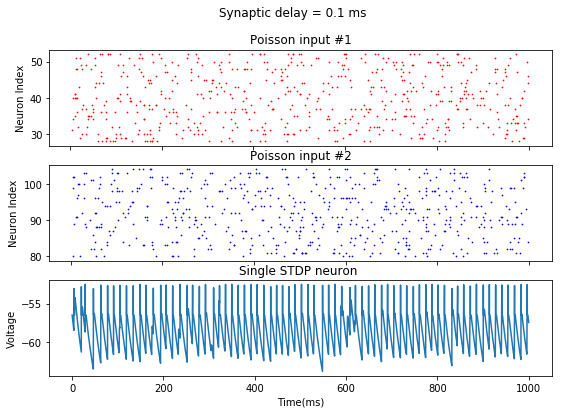

Detector found 57 clusters


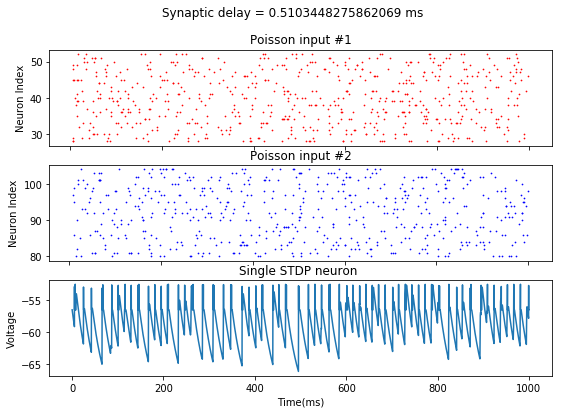

Detector found 49 clusters


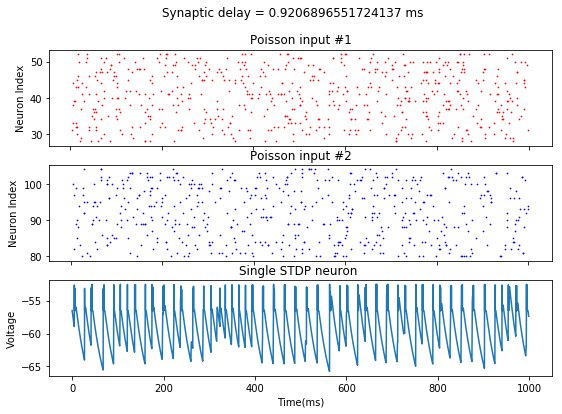

Detector found 41 clusters


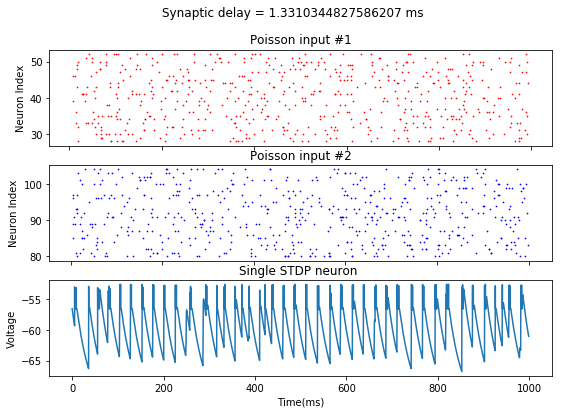

Detector found 38 clusters


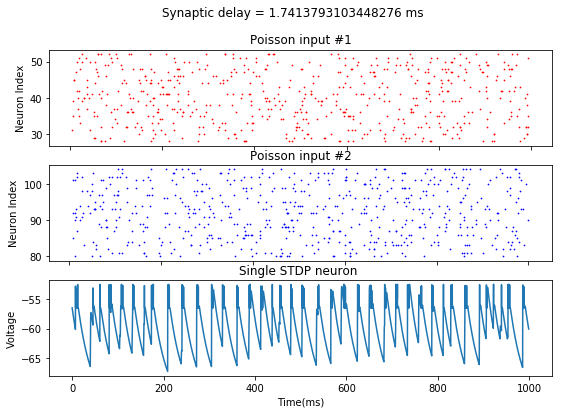

Detector found 33 clusters


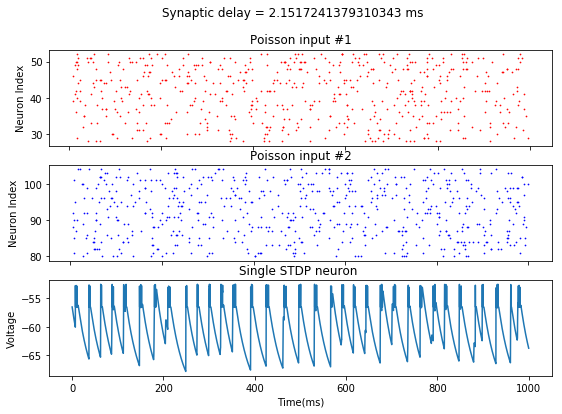

Detector found 31 clusters


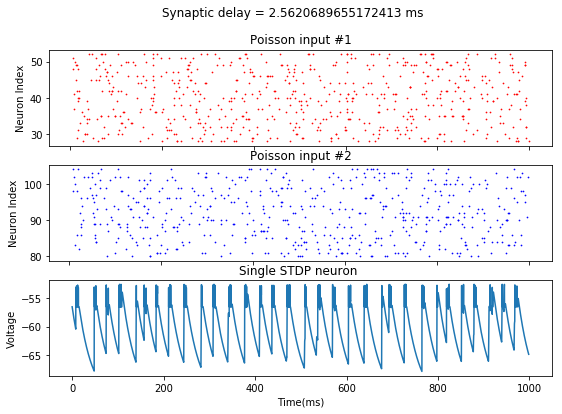

Detector found 28 clusters


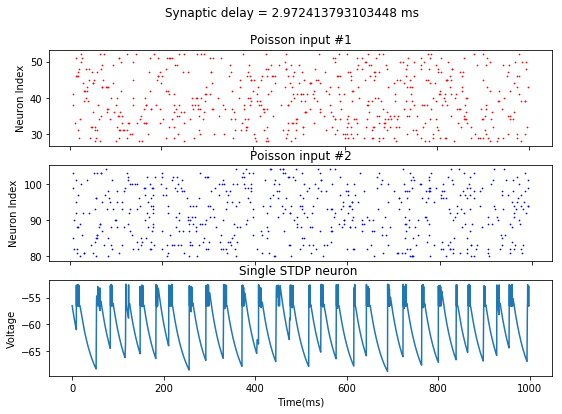

Detector found 25 clusters


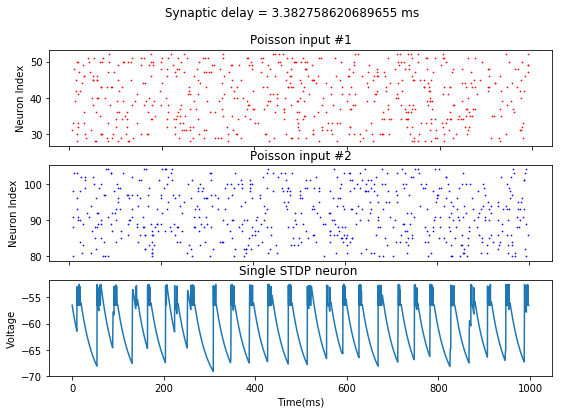

Detector found 24 clusters


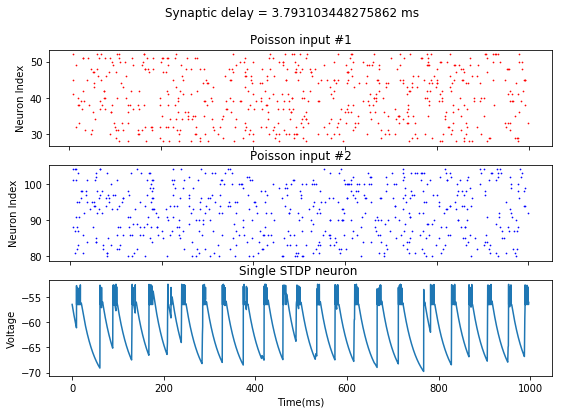

Detector found 23 clusters


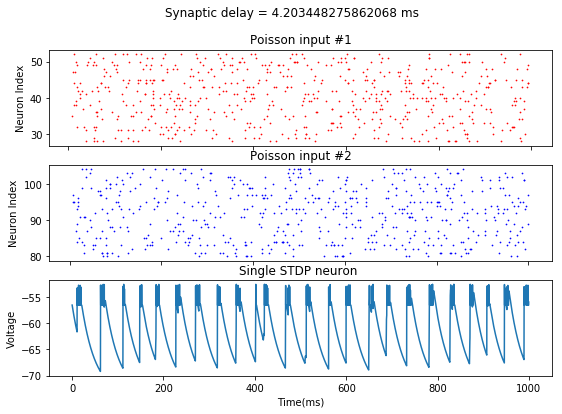

Detector found 25 clusters


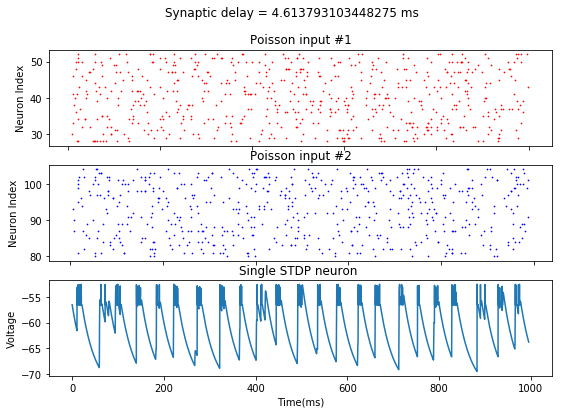

Detector found 22 clusters


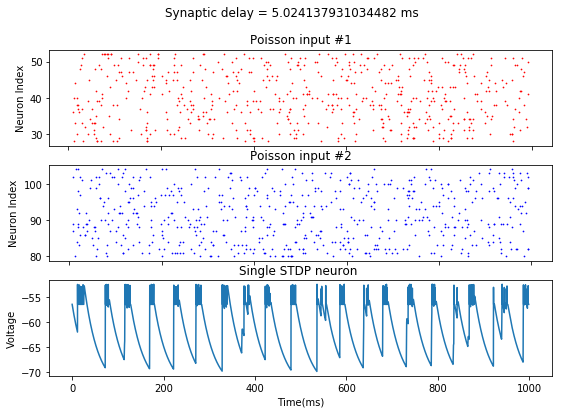

Detector found 21 clusters


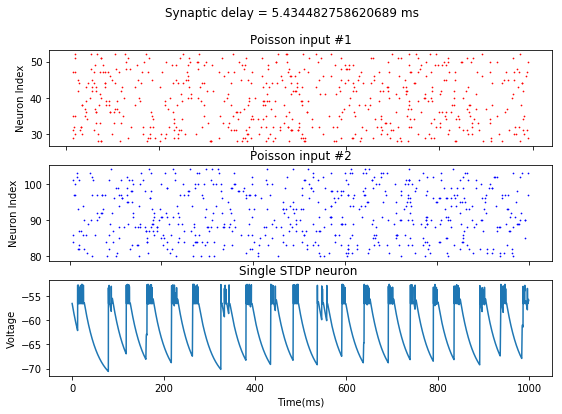

Detector found 19 clusters


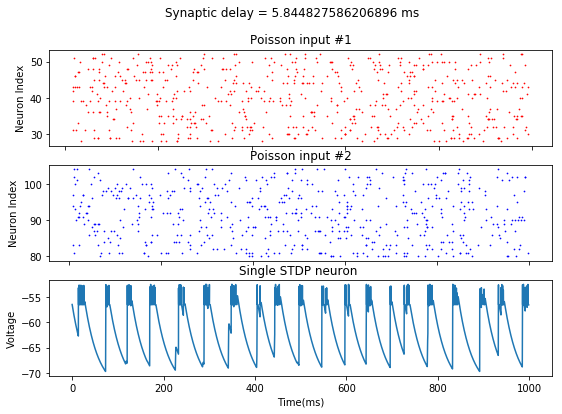

Detector found 20 clusters


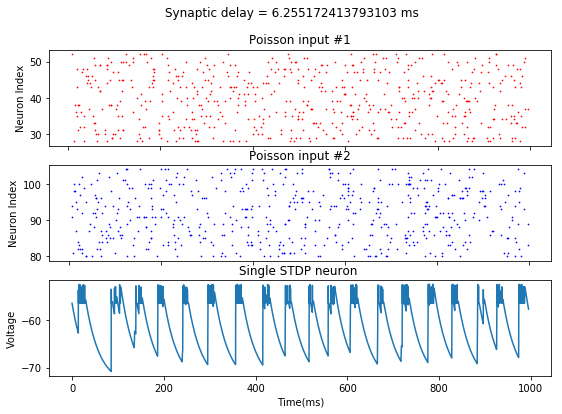

Detector found 18 clusters


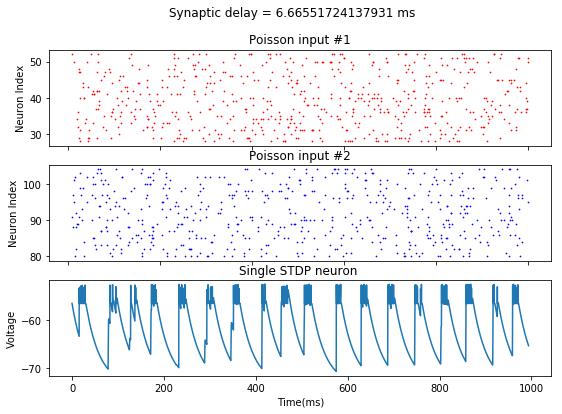

Detector found 16 clusters


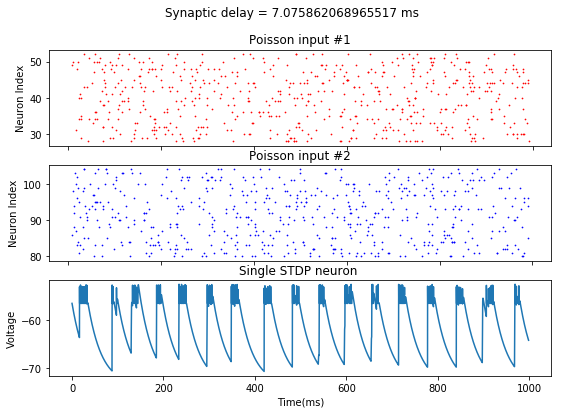

Detector found 17 clusters


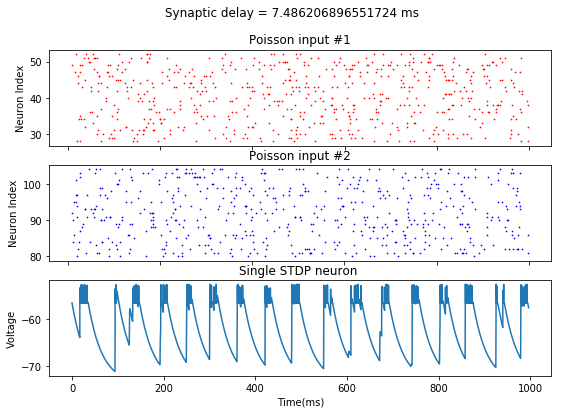

Detector found 17 clusters


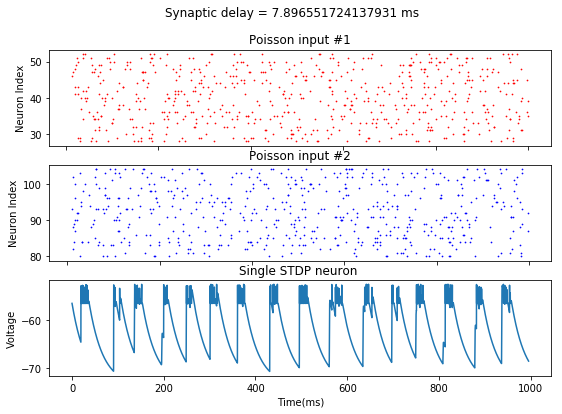

Detector found 18 clusters


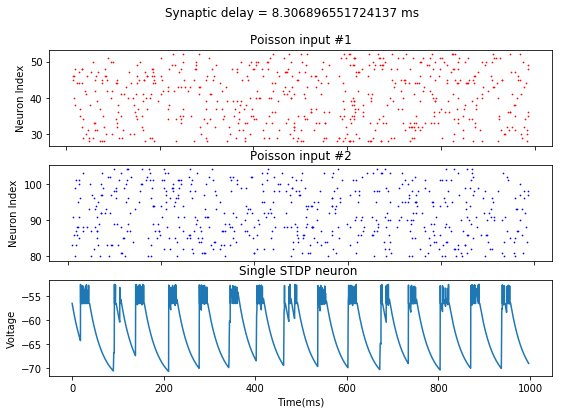

Detector found 17 clusters


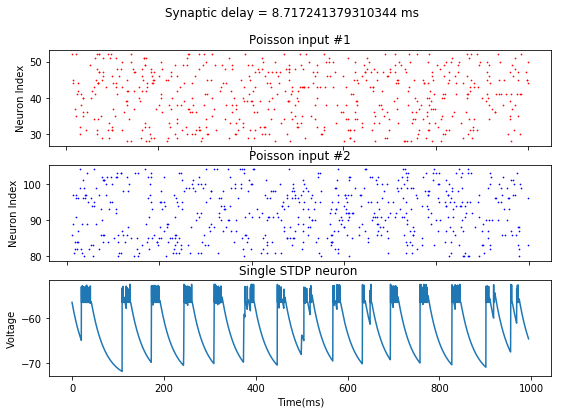

Detector found 14 clusters


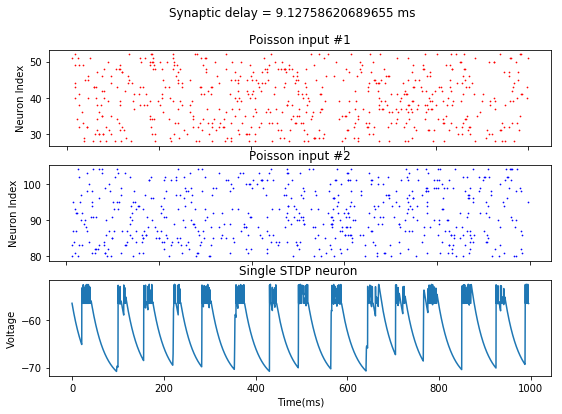

Detector found 15 clusters


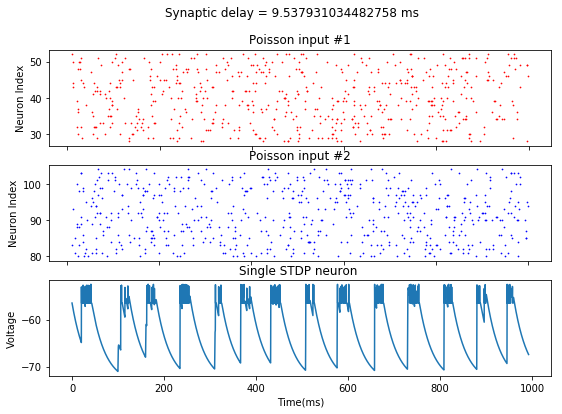

Detector found 15 clusters


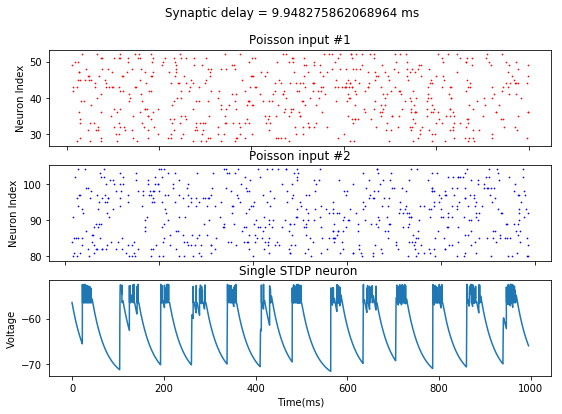

Detector found 14 clusters


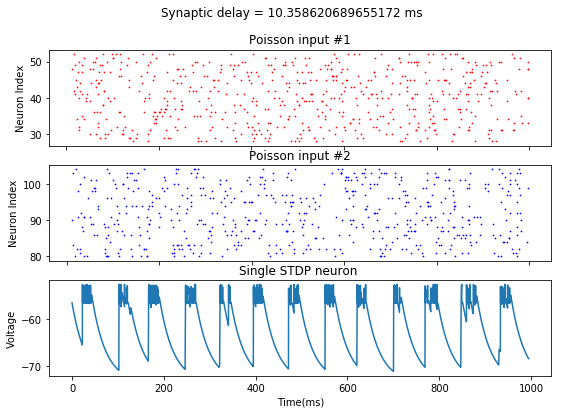

Detector found 14 clusters


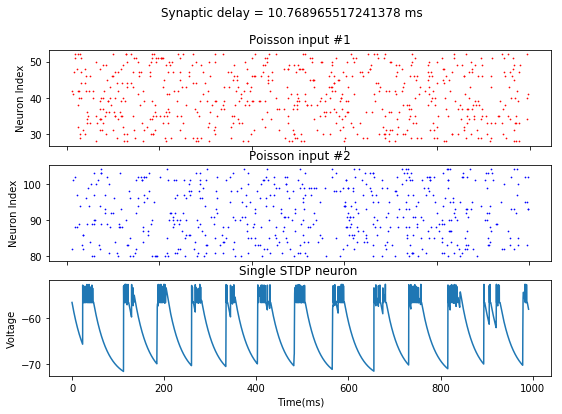

Detector found 16 clusters


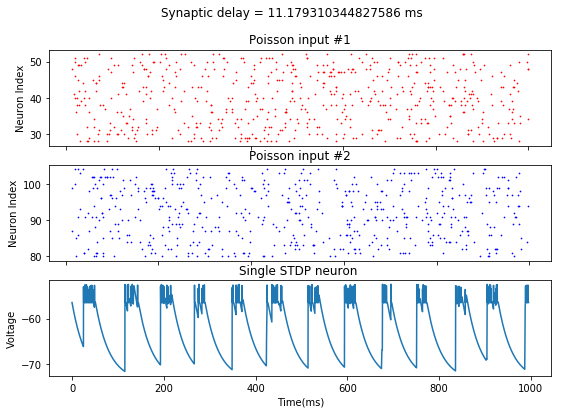

Detector found 14 clusters


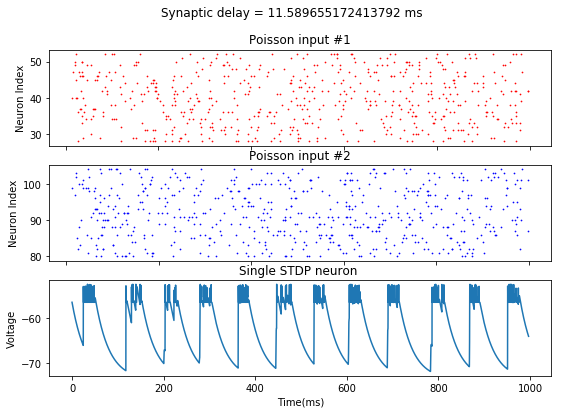

Detector found 15 clusters


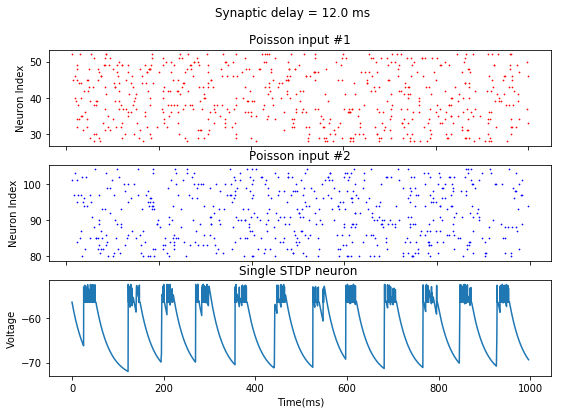

In [3]:
meta_list = []
for iterator in np.linspace(.1,12,30):
    neuron_params = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -73.6, #mV - McCormick
                 'v_thresh': -52.5 #mV - McCormick
                    }
    delay = iterator

    sim.setup(timestep=0.01)#, min_delay=delay, max_delay=delay)

    spike_source = sim.Population(25, sim.SpikeSourcePoisson(rate=26, #Hz
                                                             duration=1000),
                                        label = 'presynaptic')

    spike_source_two = sim.Population(25, sim.SpikeSourcePoisson(rate=25, #Hz
                                                             duration=1000),
                                        label = 'presynaptic')

    post = sim.Population(1, sim.IF_cond_alpha(**neuron_params),
                        initial_values={"v": neuron_params["v_reset"]}, label="postsynaptic")

    stdp_model = sim.STDPMechanism(
                    timing_dependence=sim.SpikePairRule(tau_plus=20.0, tau_minus=20.0,
                                                        A_plus=0.9, A_minus=0.9),
                    weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=3),
                    weight=1,
                    delay=delay,
                    dendritic_delay_fraction=1.)

    connections = sim.Projection(spike_source, post, sim.AllToAllConnector(), stdp_model)
    connections2 = sim.Projection(spike_source_two, post, sim.AllToAllConnector(), stdp_model)

    spike_source.record('spikes')
    spike_source_two.record('spikes')
    post.record(['spikes', 'v'])

    sim.run(1000)
    sim.end()
    
    #PLOTTING and DATA 
    post_v = post.get_data().segments[0]
    spikes_pre = spike_source.get_data().segments[0]
    spikes_pre_two = spike_source_two.get_data().segments[0]
    
    sig = post_v.analogsignals[0]
    clusters = spike_chunk_detector(signal = sig, threshold = -55, timeframe = 8, verbose = False)
    print('Detector found %s clusters' % len(clusters))
    meta_list.append(len(clusters))

    markersize = 3
    fig, axs = VanillaRasterPlot(SpikesP = spikes_pre, SpikesI = spikes_pre_two, SpikesE = post_v, param_scan = iterator,
                     spike_thresh = neuron_params['v_thresh'])
    plt.pause(.1) #mandatory pause
    
    if iterator == .1 or iterator == 12.:
        fig.savefig('./figs/2018_10_06_SingleneuronSTDP_delay_%s_ms.pdf' % iterator, format = 'pdf', dpi = 200)

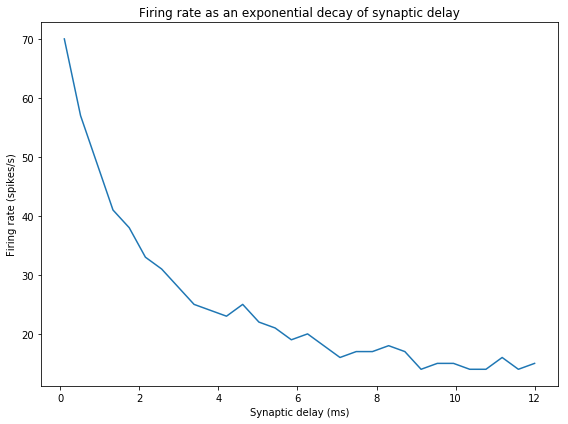

In [4]:
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(np.linspace(.1,12,30), meta_list)
ax.set_xlabel('Synaptic delay (ms)')
ax.set_ylabel('Firing rate (spikes/s)')
ax.set_title('Firing rate as an exponential decay of synaptic delay')
fig.tight_layout()
fig.savefig('./figs/2018_10_06_SingleneuronSTDP_firingrate_vs_delay.pdf', format = 'pdf', dpi = 200)